Benny Cohen

7/8/2020

M8 Data Science Assignment

In this notebook, we will be looking at a dataset about houses. The data is not current. It is from Boston around 1997-1998. We hope to be able to use it though to be able to predict whether a house mortgage would be accepted or denied. A model like this could be useful in flagging banks that are not approving mortgages objectively. 

We will do this by 

1. Importing our data and doing some eda.
2. Cleaning our data and preparing it for input to a model.
3. Building svm and k nearest neighbors models to predict if a mortgage will be denied. A denial is a binary variable where a 1 indicates a deny.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
baseurl = 'https://raw.githubusercontent.com'
username = 'cohenb51'
branch = 'develop'
repo = 'Katz_School'
filePath = 'DAV6150/M7_Data.csv'

df = pd.read_csv(f'{baseurl}/{username}/{repo}/{branch}/{filePath}')
df.head()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


### EDA

Let's begin our eda by profiling our data. We are interested in seeing the shape of the data, the data types, and the nulls, 

In [3]:
df.shape

(2381, 14)

We have 2381 rows and 14 features. This is not very many rows or features. At the same time it is above the 500 minimum amount of rows we need to create a logistic regression. We may have a harder time proving that our variables are significant though.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 14 columns):
Unnamed: 0     2381 non-null int64
dir            2381 non-null float64
hir            2381 non-null float64
lvr            2381 non-null float64
ccs            2381 non-null float64
mcs            2381 non-null float64
pbcr           2380 non-null object
dmi            2381 non-null object
self           2380 non-null object
single         2381 non-null object
uria           2381 non-null float64
comdominiom    2381 non-null int64
black          2381 non-null object
deny           2381 non-null object
dtypes: float64(6), int64(2), object(6)
memory usage: 260.5+ KB


The descriptions for the variables can be found at https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Hdma.html. In this phase we are simply exploring the data, but I will elaborate in this block about how we might consider using these variables to predict whether a mortgage should be accepted or denied. 

1. dir - debt payments to total income ratio.  This is an important variable since we intuitively can guess that a person who has much more income that debt is more trustworthy to pay back their loan. 

2. hir - housing expenses to income ratio. This variable is similar to dir just instead of debt it focuses on housing debt. Naturally, a lower ratio here means that the housing expenses is less of a burden and the more likely the applicant is to pay off their loan.  

3. lvr - ratio of size of loan to assessed value of property. We may be inclined to think that the smaller the loan, the more likely the bank will be willing to accept the risk since the applicant is showing they can pay off the value. 

4. ccs - consumer credit score. This is a discrete variable that represents how trustworthy a consumer is to pay back loans given to them. The value ranges from 1 to 6 where 1 is the best score and 6 the worst. Naturally we would think then that the lower the consumer credit score the less likely an applicant would be rejected.

5. mcs - mortgage credit score from 1 to 4 (a low value being a good score) We might expect this to be related to ccs as it is another type of credit score.

6. pbcr - public bad credit record. A person with a bad credit rating will more likely not have a mortgage accepted.

7. dmi - denied mortgage insurance. This is a binary variable for if mortgage was denied. This may be slightly leaky as if a mortgage insurance was denied, it is likely the insurance also was denied.

8. self - binary variable for if the applicant is self employed. This relates to how a person is getting their income. I'm not sure if being self employed will make you less reliable to pay back your mortgage or more likely to at this point.

9. single - is the applicant single. Single Applicants may be less trustworthy as they may only have 1 source of income. 

10. uria- 1989 Massachusetts unemployment rate in the applicant's industry. The higher the unemployment, the higher the concern that the applicant won't be able to pay back the loan.

11. condominium - is a unit a condo. A condo is like an apartment except the living spaces are owned rather than rented and common areas like stairs are shared by all the owners. Since the ownership model for condos is different, we might expect this variable to help us. 

12. black - is the applicant black. Most people in our society believe in equality. From a practical sense though, we can't be certain that this is true and certain people may have stereotypes that influence their decisions.  We can explore with this variable whether stereotypes about black people influence whether a mortgage will be denied or accepted. For example, if many people think black people are poorer, their mortgages may more likely be denied. We need to be careful with this black variable though. We don't have that many features. It's possible that black people live in a neighborhoods that tend to be poorer and more likely to be denied. We should analyze correlations between this variable and our other variables to see if black people are poorer. 

13. deny - mortgage application denied - This is our target variable. We want to know whether a mortgage application was denied. 

Now let's look at nulls.

In [5]:
df.isnull().sum()

Unnamed: 0     0
dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           1
dmi            0
self           1
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

We have 1 row will a null pbcr and 1 row with whether a person is self employed is a null. This is not so many so we will just come back to it when we do our data prep work. 

In [6]:
df.head()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


A lot of our variables are yes or no questions. It will be easier to do our analysis if we represent these as numbers. Let's say 1 is yes and 0 is no.

In [7]:
_hash = {'yes': 1, 'no': 0}
yesNoCols = ['pbcr', 'dmi', 'single', 'black', 'deny', 'self']

for col in yesNoCols:
    df[col] = df[col].map(_hash)


In [8]:
df.head()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,0.0,0,0.0,0,3.9,0,0,0
1,2,0.265,0.265,0.921875,2.0,2.0,0.0,0,0.0,1,3.2,0,0,0
2,3,0.372,0.248,0.920398,1.0,2.0,0.0,0,0.0,0,3.2,0,0,0
3,4,0.320,0.250,0.860465,1.0,2.0,0.0,0,0.0,0,4.3,0,0,0
4,5,0.360,0.350,0.600000,1.0,1.0,0.0,0,0.0,0,3.2,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028D601F77B8>,
      dtype=object)

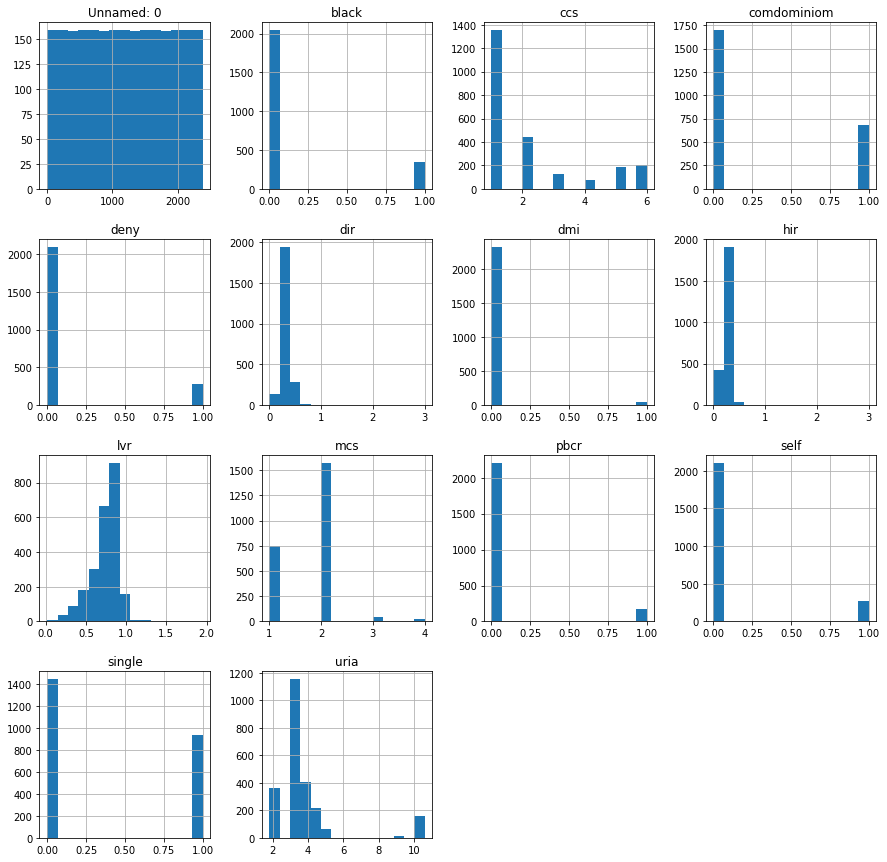

In [9]:
df.hist(figsize=(15,15), bins = 15)


The unamed column is our index column. It is autoincrementing so it won't help our model. 

1. We see that ccs, our credit index score is leftly skewed. This implies that most consumers have trustworthy credit scores. We may try to see if we can find any trends in the people who have high credit scores. 

2. condomonium - We see that this is a binary variable with most houses not being a condo. 

3. Dir and hir - These variables seems to be scaled between 0 and 1. We will need to make another graph for these variables with more bins to see the distribution. 

4. Ivr - This variable has a left skew. Low values indicate that the loan is not very big. The distribution makes sense since there probably is a set max percentage that people can take out, and a few people take out less than that, and even fewer might have some exception that let's them take out a bigger loan. 

5. mcs - Most people have a mortgage credit score of 1 or 2. Very few people have 3 or 4. We should look at these higher rows. 

6. Uria - We see that the unemployment rate is around 2-4 in most places but a few places have 9 or 10. We need to see have these are outliers since this potentially could be valuable information.

7. black - most people in Boston are not black. This confirms that blacks are a minority, which isn't really new information but is good for some validation that our data sample is a random sampling.

8. dmi - This variable has very low variance but potentially the yes's can be critical. Remember since we are going to be making a regression if this variable has a high coefficient it won't help the prediction unless the feature is set to true since this a binary variable so I think it would be okay to include it if we find something significant with it.  

9. We see more people are not single. It seems to be under 2:1 for non singles to singles. 


Most of our numeric data seems to be on the same scale between 0 and 1 but these numeric variables are all ratios like loan to property value and these values should rarely be above 1.

Let's look at dir now with more bins so we could see the distribution better. 

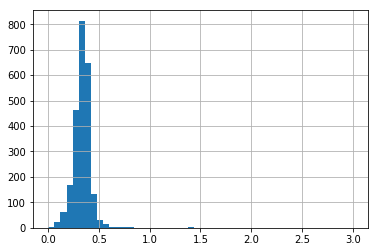

In [10]:
df.dir.hist(bins = 50)

This looks like a normal distribution with a sharp peek. It is slightly surprising how high some of these values are. We should be wary that the rows on the right side of the peak have a low income or many debts and may be more likely to have their loans rejected. 

There also appears to be a value above 1. This would mean that this person's debt is actually greater than their income. This should definitely raise some eyebrows.

In [11]:
df.dir[df.dir > 1]

620     1.16
1094    3.00
1320    1.28
1927    1.42
1928    1.42
Name: dir, dtype: float64

This explains why the x axis is all the way to 3. Someone has more than 3 * more debts than income! Surely their loan would have been rejected if this data is correct?!?

In [12]:
df.iloc[df.dir[df.dir > .7].index].sort_values('dir', ascending = False) # Let's lower the rate to .7 to look at more rows

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
1094,1095,3.0000,3.0000,0.571429,1.0,3.0,0.0,0,1.0,0,10.6,0,0,1
1927,1928,1.4200,1.1000,1.037500,1.0,1.0,1.0,0,1.0,1,3.2,1,0,1
1928,1929,1.4200,1.1000,1.037500,1.0,1.0,1.0,0,1.0,1,3.2,1,0,1
1320,1321,1.2800,0.7300,0.707547,1.0,1.0,0.0,0,1.0,0,4.3,0,0,0
620,621,1.1600,0.7400,0.752688,1.0,2.0,0.0,0,0.0,0,4.3,0,0,1
411,412,0.9500,0.4400,0.547059,6.0,3.0,0.0,0,1.0,0,10.6,0,0,0
819,820,0.8300,0.4900,0.945578,5.0,2.0,0.0,0,0.0,1,3.9,0,1,1
1104,1105,0.8300,0.7200,0.716292,3.0,2.0,0.0,0,0.0,1,3.6,0,0,0
571,572,0.8142,0.3933,0.516529,3.0,2.0,1.0,0,0.0,1,3.2,0,1,0
1010,1011,0.7800,0.7200,0.900000,1.0,2.0,0.0,0,0.0,0,3.6,1,0,1


This graph is ordered by hir. It definitely appears that most of these rows are being denied. I am a bit suspicious of row with index 1094. 3.0 is a very round number when calculating a ratio and is very large compared to all of the others. We may want to apply min max scaling if we use this in a production setting knowing that data like this could come in. I think the rows with 1.1 are more possible. It technically is possible to have more debts than payments and I don't think we should lose those rows. 

I would expect to find something similar when looking at hir, the housing expenses to income ratio, since this is also a ratio to income.

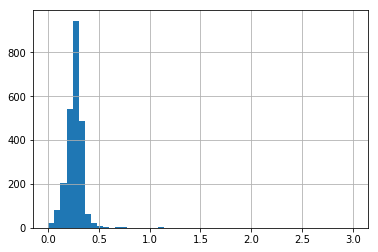

In [13]:
df.hir.hist(bins = 50)

Yes, we see here a very similar distribution. 

In [14]:
df.iloc[df.hir[df.hir > .7].index].sort_values('dir', ascending = False) # Let's lower the rate to .7 to look at more rows

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
1094,1095,3.00,3.00,0.571429,1.0,3.0,0.0,0,1.0,0,10.6,0,0,1
1927,1928,1.42,1.10,1.037500,1.0,1.0,1.0,0,1.0,1,3.2,1,0,1
1928,1929,1.42,1.10,1.037500,1.0,1.0,1.0,0,1.0,1,3.2,1,0,1
1320,1321,1.28,0.73,0.707547,1.0,1.0,0.0,0,1.0,0,4.3,0,0,0
620,621,1.16,0.74,0.752688,1.0,2.0,0.0,0,0.0,0,4.3,0,0,1
1104,1105,0.83,0.72,0.716292,3.0,2.0,0.0,0,0.0,1,3.6,0,0,0
1010,1011,0.78,0.72,0.900000,1.0,2.0,0.0,0,0.0,0,3.6,1,0,1
607,608,0.73,0.71,0.606061,1.0,1.0,0.0,0,0.0,1,3.9,0,0,0


We have less rows that are above .7 and all of these rows were found above. 

This tells us something interesting: since hir and dir are both ratios of income and hir specifically refers to housing expenses we should expect hir to always be less than dir. Let's check this. 

In [15]:
df[df.hir > df.dir]

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
289,290,0.28,0.33,0.628571,1.0,2.0,1.0,0,0.0,0,3.2,0,0,0
349,350,0.00,0.29,0.629496,1.0,1.0,0.0,0,0.0,0,3.1,0,0,0
1179,1180,0.24,0.26,0.495979,3.0,1.0,0.0,0,0.0,0,3.6,0,0,1
1477,1478,0.30,0.33,0.923567,1.0,2.0,0.0,0,0.0,1,3.1,0,0,0
1926,1927,0.24,0.29,0.810000,1.0,2.0,0.0,0,0.0,0,3.9,0,0,0


We have 4 rows where the housing expenses are less than the debt payments. The predicate is true for the other 2,000 + rows. 

One noteworthy fact about these rows is that the hir and dir is very low. I don't think we should generalize anything from this and it's possible the ratio is so small it doesn't really mean anything for us. 

One thing we should definetly check at this point though is for correlations. Since hr and dir are both ratios to income, we should be wary that they are correlated. 

A key point is that we shouldn't be using logistic regression if we have multicollinearity. We also need to be alert for linear relationships that we can use as input to our model.

The pearson coefficient tells us how one variable relates to another. This graph can help us find strong relationships but this isn't the perfect metric.

We really should be using the spearman correlation as we have ordinal variables. We can use this graph though to see the relationship between dir and hir.

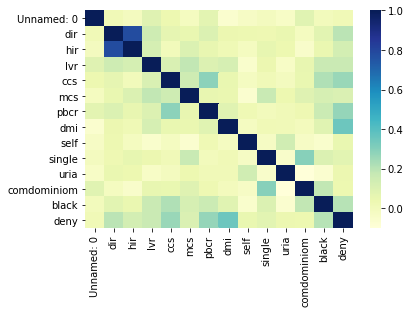

In [16]:
import seaborn as sns
corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

We definetly see the correlation between dir and hir. 
We also need to be wary of some other correlations when we create our logistic models. 

1. pbcr and ccs have a mid - strong correlation
2. whether a person has a condo is related to if they are single or black. 
3. ccr has a relationship with being black. 

We will focus on our target variable for our eda 


In [17]:
#For reference, here are spearman scores 
from scipy import stats
spear = pd.DataFrame(stats.spearmanr(df)[0], columns = df.columns, index = df.columns)
spear

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
Unnamed: 0,1.000000,0.032786,-0.015561,0.084176,0.027371,-0.011367,0.075379,-0.061510,-0.028308,-0.008993,-0.032967,0.085297,0.002128,0.017653
dir,0.032786,1.000000,0.549744,0.210652,0.096472,0.031292,0.105434,0.066570,-0.025903,0.023562,0.008979,-0.005560,0.117893,0.168131
hir,-0.015561,0.549744,1.000000,0.151541,-0.011548,0.127049,0.042290,0.020150,-0.084985,0.083164,0.011731,-0.047787,0.073469,0.089285
lvr,0.084176,0.210652,0.151541,1.000000,0.103254,0.235034,0.118545,0.124437,-0.090851,0.044693,-0.003935,0.053023,0.192415,0.183613
ccs,0.027371,0.096472,-0.011548,0.103254,1.000000,0.106372,0.253992,0.050688,0.002065,0.009217,0.017726,0.017933,0.199460,0.244121
mcs,-0.011367,0.031292,0.127049,0.235034,0.106372,1.000000,0.043000,0.048338,-0.083617,0.188779,0.036777,0.108531,0.133848,0.108770
pbcr,0.075379,0.105434,0.042290,0.118545,0.253992,0.043000,1.000000,0.085057,0.033126,0.002572,0.014627,0.029302,0.160396,0.271491
dmi,-0.061510,0.066570,0.020150,0.124437,0.050688,0.048338,0.085057,1.000000,-0.014945,0.019026,0.028588,-0.005473,0.086936,0.352165
self,-0.028308,-0.025903,-0.084985,-0.090851,0.002065,-0.083617,0.033126,-0.014945,1.000000,-0.022293,0.117998,-0.032125,-0.054610,0.051186
single,-0.008993,0.023562,0.083164,0.044693,0.009217,0.188779,0.002572,0.019026,-0.022293,1.000000,-0.028309,0.298099,0.102328,0.076389


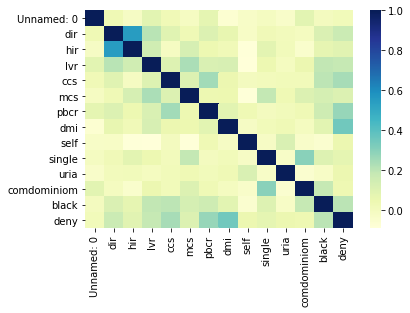

In [18]:
sns.heatmap(spear, 
        xticklabels=spear.columns,
        yticklabels=spear.columns,
        cmap="YlGnBu")

We should be using our spearman coef for our ordinal data. Our correlations with this metric are slightly different but the overall we see the same trends as we did with the r2 scores.

In [19]:
spear.deny.sort_values()

Unnamed: 0     0.017653
comdominiom    0.039675
self           0.051186
uria           0.053347
single         0.076389
hir            0.089285
mcs            0.108770
dir            0.168131
lvr            0.183613
black          0.205211
ccs            0.244121
pbcr           0.271491
dmi            0.352165
deny           1.000000
Name: deny, dtype: float64

Here we are going to focus on our target variable, We see that all our correlations are positive. The strongest correlation we have is with dmi, denied mortgage insurance. This correlation though is slightly suspicious. Recall the distribution for dmi...

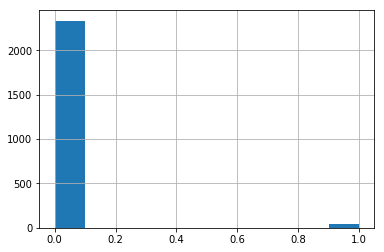

In [20]:
df.dmi.hist()

This is a straight binomial variable and almost all the values are 0. 

Let's look at the rows with 1.

In [21]:
dmiIs1 = df[df.dmi == 1]

In [22]:
len(dmiIs1)

48

Only 48 rows of our 2381 values have nulls. 

In [23]:
dmiIs1.deny.mean()

0.9166666666666666

This tells us that 91 percent of the people who had their mortgage insurance denied had their application denied. Although we only have 48 rows, and it will be hard to prove this is significant, this shows that this feature is really important. 

The r2 value from the correlation matrix is slightly misleading since only the values with 1 help us explain the variance and when this value is 0 we don't really know anything about 

In some ways this feature is slightly leaky because if we know that that the mortgage insurance was denied, the mortgage itself would probably be denied.

Let's continue looking at our correlations and other distributions.

In [24]:
spear.deny.sort_values()

Unnamed: 0     0.017653
comdominiom    0.039675
self           0.051186
uria           0.053347
single         0.076389
hir            0.089285
mcs            0.108770
dir            0.168131
lvr            0.183613
black          0.205211
ccs            0.244121
pbcr           0.271491
dmi            0.352165
deny           1.000000
Name: deny, dtype: float64

The next highest correlation was pbcr. 

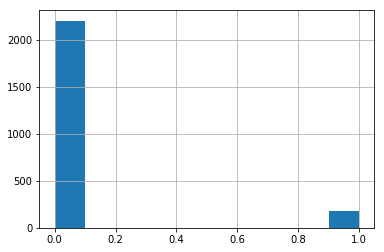

In [25]:
df.pbcr.hist()

We see a simmilar distibution to dmi, just here a few more rows are 1. 

In [26]:
pbcrIs1 = df[df.pbcr == 1]
pbcrIsNot = df[df.pbcr == 0]

len(pbcrIs1)

175

In [27]:
pbcrIs1.deny.mean() #the probability that will be denied, given pbcr is 1

0.4342857142857143

In [28]:
pbcrIsNot.deny.mean()

0.09478458049886622

We see that the probability that a mortage will be denied is higher if they have a bad public rating. As we explained at the start, this intuitively makes sense.

Let's compare this to what the baseline is...

In [29]:
df.deny.mean()

0.11969760604787905

There definitely is at least some difference in the mean based on whether the person has a bad credit rating. 

The next highest correlation we need to look it is ccs.

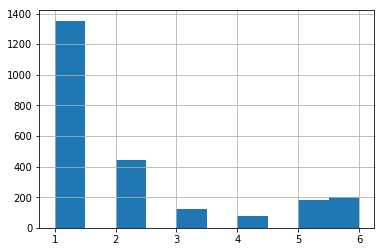

In [30]:
df.ccs.hist()

Once again most of the values are 1 and a few are high. We are starting to notice the trend, that the outliers are what is telling us if the mortage was accepted or denied.

In [31]:
highccs = df[df.ccs > 1]

In [32]:
highccs.deny.mean()

0.19552529182879377

We see that the probability that a morgage is denied is higher when the mortgage rating is lower. .19 is almost 2x the baseline .1 percent of denies. 

In [33]:
highccs = df[df.ccs > 2]
highccs.deny.mean()

0.2555366269165247

And the higher the ccs, the higher the chance there is a deny. 

Note: These relationships actually are positive because I defined a deny as being a 1 and a lower ccs implies greater credibility. Thus the higher the ccs, ie - the less credibility the person has, the greater the chance of a deny. 

Let's look at blacks.

In [34]:
variable_representing_black_skinned_people = df[df.black == 1]
len(variable_representing_black_skinned_people)


339

In [35]:
variable_representing_black_skinned_people.deny.mean()

0.2831858407079646

This also is much higher than our base .1 rate.

The next highest correlation is with dir which we already looked at. The highest after that is lvr.

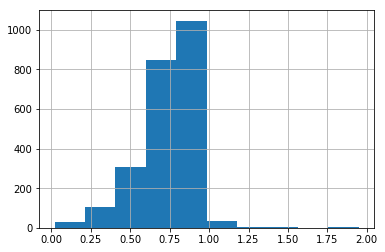

In [36]:
df.lvr.hist()

Recall lvr is the ratio of the loan to property value. A lower lvr should in theory indicate the loan is small and therefore the mortgage should be accepted. Let's see if this is true.

It is also somewhat surprising that we could have a value above 1. 

From reading this article https://budgeting.thenest.com/can-apply-home-loan-larger-house-purchase-20988.html we see that indeed there is a cap to the max loan; only around a max of 75-95 percent of the property value normally can be loaned, however there are exceptions with negative equity loans where lenders let people take out more money. 

This is supported by our graph. We see that the graph comes to a sharp peak somewhere between this 75-95 percent and then drops off. We shouldn't per say think this is bad data since as that article mentions there are exceptions. 

In [37]:
highLvr = df[df.lvr > 1]

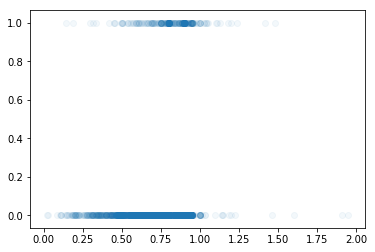

In [38]:
plt.scatter(df.lvr, df.deny, alpha = .05)

This is what a scatterplot of lvr on the x axis to deny on the y axis. It definetly appears that the points at the top of the graph with y =1 (ie - they were denied), are further to the right, indicating that higher lvr's, that is higher loans, are more likely to be denied. 

The last few variables we should look at are condo, uria, self, and single.  

In [39]:
df.groupby('comdominiom').mean()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,black,deny
comdominiom,,,,,,,,,,,,,
0,1153.702655,0.331663,0.258176,0.731508,2.062606,1.690101,0.068477,0.020649,0.122786,0.300885,3.904233,0.101475,0.111504
1,1283.155977,0.328715,0.248354,0.753208,2.249271,1.797376,0.086006,0.018950,0.100583,0.622449,3.453936,0.243440,0.139942


As I am looking at this, I am looking for any significant differences between the features. For the most part, they seem about equal in all the features. 
The 2 main things to observe here are that more singles and blacks live in condos. We may be inclined to believe that is because  other people can afford bigger houses. Does this mean then that blacks are poorer?

In [40]:
df.groupby('black').mean()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,deny
black,,,,,,,,,,,,,
0,1190.404016,0.327464,0.253533,0.725959,1.966267,1.694770,0.056345,0.015181,0.123469,0.373164,3.829175,0.254163,0.092556
1,1194.589971,0.350989,0.266266,0.808848,3.020649,1.879056,0.176991,0.050147,0.073746,0.516224,3.445133,0.492625,0.283186


The biggest difference with blacks and other groups is that blacks have a significatnly higher ccs, credit score. This means that blacks are not trusted as much to pay back their loans. lvr is also 8 percent higher which tells us the loans they are taking out are bigger. The dir and hir are higher but not by that much though. 

In [41]:
df.groupby('self').mean()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,single,uria,comdominiom,black,deny
self,,,,,,,,,,,,,
0.0,1198.143604,0.329407,0.255845,0.741451,2.126010,1.733714,0.070851,0.020922,0.397527,3.670043,0.293390,0.149311,0.113647
1.0,1132.469314,0.341492,0.251555,0.709875,2.043321,1.624549,0.093863,0.014440,0.361011,4.567509,0.249097,0.090253,0.166065


Self represents a self employed person. We see that that almost all the variables are constant except with deny. Self employed people maybe are less trusted to pay back their loans.

Finally, let's see how the unemployment rate in a neighborhood impacts our deny rate.

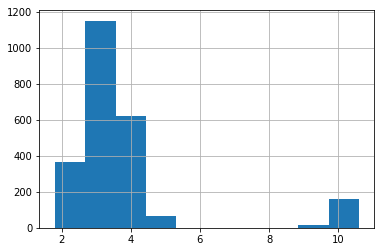

In [42]:
df.uria.hist()

Most values are around 2-4. The rest are near 9 and 10. Let's look at these outliers.

In [43]:
high = df[df.uria > 4]
pd.DataFrame([high.mean(), df.mean()])

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1130.184783,0.340691,0.260566,0.730711,2.021739,1.752174,0.076087,0.023913,0.202174,0.356522,6.778913,0.195652,0.084783,0.152174
1,1191.000000,0.330814,0.255346,0.737760,2.116387,1.721008,0.073529,0.020160,0.116387,0.393532,3.774496,0.288114,0.142377,0.119698


The deny rate is slightly higher but not so much. Similarly, more of these people live in condos. As a whole this variable seems very similar to what we found when we looked at self. Although it intuitivly makes sense that a higher uria would make a loan more likely to be denied, maybe this isn't true because this variable is applicable to the neighborhood the person is moving into and not the applicant himself. 

In [44]:
df.uria.value_counts()

3.200000     877
3.100000     275
3.900000     229
4.300000     220
1.800000     217
3.600000     174
10.600000    159
2.000000     148
5.300000      65
8.900000      16
3.774496       1
Name: uria, dtype: int64

As a whole, I am finding these values very suspicious. Most of the variables are rounded to the tenths place and then we have one row with 3.77449 which is a lot of decimal points. On top of this, this variable is measuring unemployment rate and it seems strange to me that we would have such a big gap between so many of these values. We see here https://www.homefacts.com/unemployment/Massachusetts/Suffolk-County/Boston.html that unemployment rates were low in Boston in 1997 making me question these rows with high values.

I am inclined to drop this feature mainly because we don't see so much of a difference in deny rate. I also don't know how our model will do on present day data if we include this where unemployment rates are much different. 

In [45]:
len(high)

460

In [46]:
df.groupby('single').mean()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,uria,comdominiom,black,deny
single,,,,,,,,,,,,,
0,1195.979224,0.328133,0.250691,0.731265,2.097645,1.648892,0.073407,0.018006,0.122576,3.850208,0.179363,0.113573,0.099723
1,1183.326574,0.334944,0.262519,0.747770,2.145268,1.832146,0.073718,0.023479,0.106838,3.657817,0.455710,0.186766,0.150480


It appears that single people are more likely to be denied. This may be because they only have a single income.

But at the same time 460 rows is somewhat small. 

Another thing we should check for is collinearity... We already saw a few like between dir and hir, and condomonium and black, and pbcr and ccs.

Let's see if people who take out higher loans have a lower income ratio.

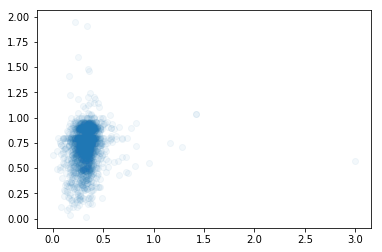

In [47]:
plt.scatter(df.dir, df.lvr, alpha = .05)

There doesn't seem to be any big correlation. This makes sense though since as we saw lvr is a capped variable and most people may try to take out as much as they could irrespective of their income.

### EDA Wrapup

1. We saw that our dataset consists of many binary variables. These variables consist of a majority class and a minority. We found that belonging to the minority class in these distributions effects the chance that the applicant will be denied.
2. We saw that we need to be cognizant of collinearity in our dataset. Variables like dir are inherently related since they are both ratios of income. We also saw relationships between less obvious variables like single and black to condominium. 
3. We have a total of 2 nulls in our dataset. 

### Data Prep

Let's first drop uria and index for the reason I mentioned above.

In [48]:
df.drop(['uria', 'Unnamed: 0'], axis = 1, inplace = True)


We should start by dealing with our nulls.

In [49]:
df.isnull().sum()

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           1
dmi            0
self           1
single         0
comdominiom    0
black          0
deny           0
dtype: int64

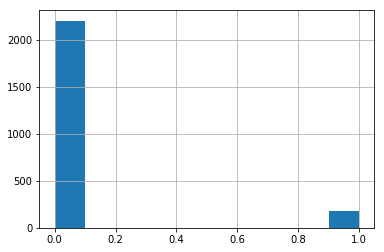

In [50]:
df.pbcr.hist()

pbcr is bad credit ratting.

In [51]:
df.groupby('pbcr').mean()

,dir,hir,lvr,ccs,mcs,dmi,self,single,comdominiom,black,deny
pbcr,,,,,,,,,,,
0.0,0.327723,0.253809,0.732696,1.981406,1.712472,0.016780,0.113832,0.393197,0.284354,0.126531,0.094785
1.0,0.369754,0.274708,0.801777,3.817143,1.828571,0.062857,0.148571,0.394286,0.337143,0.342857,0.434286


In [52]:
df[df.pbcr.isnull()]

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,comdominiom,black,deny
2380,0.330814,0.255346,0.700783,2.116387,1.721008,NaN,0,NaN,1,0,0,0


This row actually is the same row that is missing self, if the person is self employed. The other variables seem to be around what the mean values for the other variables are.

We could try guessing why this value is null but it seems really random and just a data entry/programming mistake since it's an isolated case.

Since we won't gain anything by imputing the value as all the other variables are around the mean of the features let's just drop this row. We aren't losing anything by doing this as it is 1 row.

In [53]:
df.drop(df[df.pbcr.isnull()].index, inplace = True)

In [54]:
df.isnull().sum().any() #Just to validate.

False

Next we need to create dummy variables. In our case though, all of our non ordinal categorical is binary so we don't have to do anything for this step.

We can't create dummy variables for our ordered categorical variables ( as in ccs) as we would be losing the ordering by doing so. We probably should leave them as they are since we want to maintain that each feature is one away from the previous like an ordinal encoder would do. The main important thing here is that each row is equidistant from the previous one which is true in our dataset.

What to do with our ratios is more interesting. I would be inclined to leave them as is since in theory they all should be between 0 and 1 but we factually saw that this isn't true. 

We also saw saw outliers. These outliers are important to us since the outliers are what is going to tell us if a mortgage was denied.

Min Max scaling simply  subtracts the minimum value in the feature and then divides by the range. This shouldn't effect any of our outliers and this will put them on the same scale. Although, all the variables are in fact ratios with a max around 1, we saw this isn't completly true and some values are above 1. I think it will just be slightly cleaner to bound these values. 

In [55]:
from sklearn import preprocessing
cols = ['dir', 'hir', 'lvr']
mm_scaler = preprocessing.MinMaxScaler()
df[cols]= mm_scaler.fit_transform(df[cols])


Now since our outliers tell us a lot of information, we might try binning them. 

In [56]:
df_c = df.copy()

In [57]:
columns = ['dir', 'hir', 'ccs', 'mcs', 'lvr', 'hir'] #The non binary columns we saw differences with in predicting deny
for column in columns:
    print(column, df[column].std())
    newCol = f'IsLargeOutlier_{column}'
    df[newCol] = df[column].map(lambda x: 1 if ((x - df[column].mean())/df[column].std() > 1.5) else 0 )

dir 0.035752428200729325
hir 0.0322185370420272
ccs 1.6667205864799912
mcs 0.5372816153447326
lvr 0.09261708694484226
hir 0.0322185370420272


### Rerun our Eda...

The only transformations we really did was add a few new outlier columns, drop a row, and perform min max scaling on a few features. We just want to be sure that we did not change any of our distributions. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028D662F8EF0>,
      dtype=object)

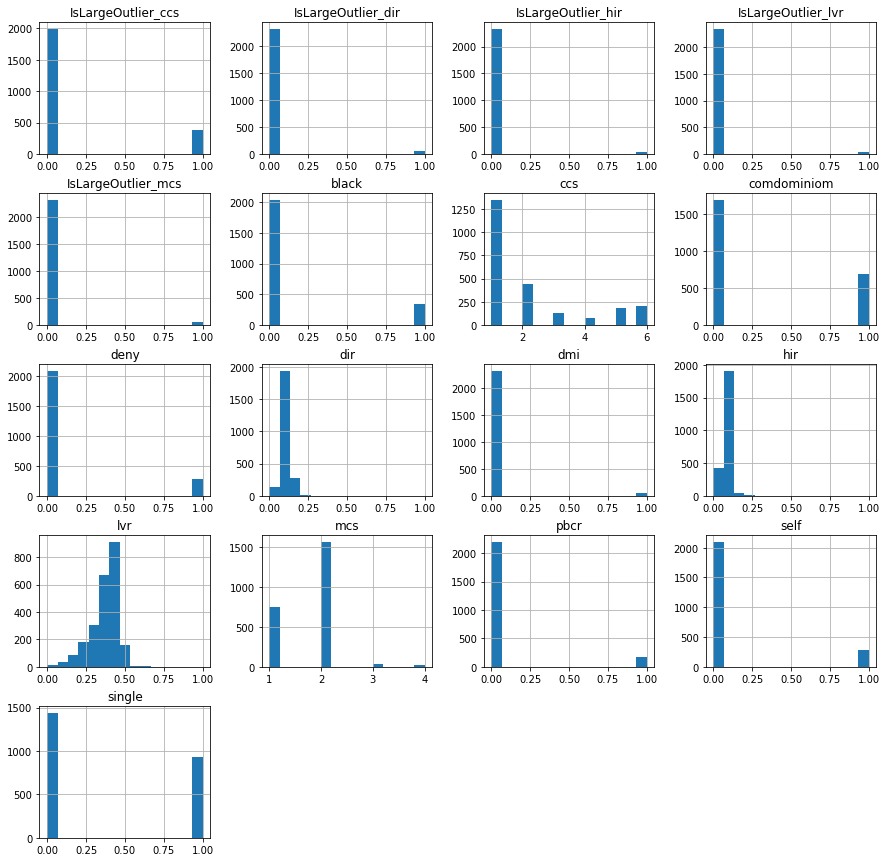

In [58]:
df.hist(figsize=(15,15), bins = 15)

All of our distributions look the same. Our outlier columns are very small, but this was the goal.

### Model Creation.


In this section, we will be creating our models. Our strategy will be to use the variables which we saw impact the percentage of denials from the eda. We will also see if using the variables which explicitly point out the outliers with the bins do better.

We will first start by creating a logistic regression model to use as a baseline. We will use the model we chose as the best model for module 7. See the last section in https://github.com/cohenb51/Katz_School/blob/develop/DAV6150/m7/B_Cohen_M7_assn.ipynb for more details. 

This is how we chose our columns...

1. dmi - We saw above that rows with denied insurance had a 90 percent chance of having a denied mortgage. As we said above, this is slightly leaky but not applicable to most rows. 
2. pbcr - A bad public credit rating - We saw above that people with a high pbcr are more likely to be denied. 
3. dir, ccs, lvr - We saw above that people who had high debts, a bad consumer credit rating, and loans relative to property size were more likely to be denied in our eda. We saw that binning them in our logistic regression model did better.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df.drop('deny', axis =1)
y = df.deny
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [60]:
m2Cols = ['dmi', 'pbcr', 'IsLargeOutlier_dir', 'IsLargeOutlier_ccs', 'IsLargeOutlier_lvr', ]


In [61]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train[m2Cols],y_train)
pred = logistic_regression.predict(X_train[m2Cols])

In [62]:
coefs = logistic_regression.coef_
coefMap = {m2Cols[i]: coefs[0][i] for i in range(len(m2Cols))} 
coefMap

{'dmi': 3.6468111954741365,
 'pbcr': 1.6384927203414168,
 'IsLargeOutlier_dir': 1.772072947006964,
 'IsLargeOutlier_ccs': 1.1784010107558933,
 'IsLargeOutlier_lvr': 1.6149799911828744}

dmi - a 1 indicates the mortgage insurance was denied. Therefore, if a mortgage insurance was denied it is highly likely that the mortgage was denied. It is no surprise that this has the highest coefficient since it is somewhat leaky. Remember this feature is binary. If dmi is 0 this coefficient won't impact the prediction so although the coefficient is high it won't affect most of the rows.

Both dir and ccs are around the same. This makes sense as dir tells us directly how much debt a person has. The more debt a person has, the more risk there is in making the loan. Lvr tells us how much money the loan is relative to the property amount. The higher the lvr amount, the higher the loan and therefore the less likely a person is to pay back the loan. 

ccs has the lowest at 1.1. CCS tells us how much consumer credit a person has. It makes sense that this variable would be lower than the ones above since the other variables relate to how much debt a person currently has and a loan how much the person is currently asking for while ccs is more of a history. It still though has importance as it's coeficent is not that much lower. 



In [63]:
from sklearn import metrics
metrics.confusion_matrix(y_train, pred)

array([[1545,   28],
       [ 142,   70]], dtype=int64)

In [64]:
from sklearn import metrics
accuracy_score = []
sc = metrics.accuracy_score(y_train,pred)
accuracy_score.append(sc)

In [65]:
sc

0.9047619047619048

Our accuracy is only around 2 percent higher than avg. 

In [66]:
df.deny.mean()

0.11974789915966387

We see that our null error rate is 88 percent so 90 percent accuracy is not that good.

In [67]:
precision_score = []
sc = metrics.precision_score(y_train,pred)
precision_score.append(sc)
sc

0.7142857142857143

Our precision is around 71 percent which is not that bad. 

In [68]:
recall_score = []
sc = metrics.recall_score(y_train,pred)
recall_score.append(sc)
sc

0.330188679245283

Our recall is around .33. This tells us that we are missing a lot of cases where the true value was a denial. This is a problem since it can cause people to allow mortgages that may be more prone to not be payed off.

In [69]:
f1_score = []
sc = metrics.f1_score(y_train,pred)
f1_score.append(sc)

Our f1 score is a weighted average of recall and precision. We see here that it suffers because of the low recall.

Our roc score tells us the area under the roc curve. It ranges between 0 and 1 with .5 being a blind guess. 

Below, is the graph of the roc curve. On the y axis we have the true positive rate (recall) and on the x axis we have false positive rate (1- specifity) 
We see that our auc, area under the curve, is .77. The best would be 1 and random would be around .5 so our model is somewhat useful. We see that the higher the recall, the higher the false positive rate, or fewer false negatives. For example, With a recall around .6, our fpr is around .2 or our specifity is around .8. That means we are identifying 80 percent of the negative cases where mortgages were accepted.  

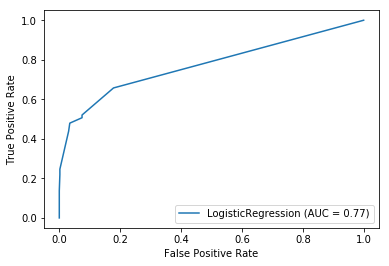

In [70]:
metrics.plot_roc_curve(logistic_regression, X_test[m2Cols], y_test) 

Let's use cross validation to see how are model does on unseen data. Let's use roc_auc as our scoring metric. Accuracy isn't so meaningful here as our accuracy is only 2-3 percent higher than a blind guess. =We will use a cv score of 5 as that is a standard number.

In [71]:
from sklearn.model_selection import cross_val_score
cross_val_score(logistic_regression, X_train[m2Cols], y_train, cv = 5, scoring = 'roc_auc')

array([0.74463341, 0.78227513, 0.77592593, 0.76088728, 0.7139683 ])

Our numbers are close together so we aren't overfitting.

### Knn Models

Knn is a model that messures the distance between 2 points. It classifies a data point based on which class it is closer to. 

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
KNeighborsClassifier?

The KNN classifier takes in some arguments that can be helpful to us. 

1. The type of distance metric to use. This is something we can empirically determine by trying out different values.

2. The number of neighbors - the more neighbors we have, the smoother our model will be, although we may mislabel more points - that is the higher k the less variance but more bias. 

3. A weight function - Should we be weighting values farther away the same as points closer. Our dataset is small enough that it probably just makes sense just to try both ways. It may perform differently based on which distance metric we choose.  

In order to determine the best parameters, we could use grid search. We should use f1 scoring as that is a weighted average of precision and recall. Both are important here, recall a bit more perhaps since we don't want to cost a bank extra money by giving a loan that the person won't be able to pay off. 

In [74]:
from sklearn.model_selection import GridSearchCV


In [75]:
grid_params = {
    'n_neighbors' : [3,5,7,11,15,19],
    'weights': ['uniform', 'distance'],
     'metric' : ['euclidean', 'manhattan' ] 
}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, cv = 5, scoring = 'f1')

Which columns should we use? I think we should start by using the columns that did best with the logistic regression so we can directly compare how they do with binned columns. We probably should expect knn to do worse with this type of data because knn is going based off of distance.

In [76]:
gsResults = gs.fit(X_train[m2Cols],y_train)

In [77]:
gsResults.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

We see the best was with 11 neighbors, using Manhattan distance, and uniform weights. I'm actually surprised that the best number of k would be so high. I would have thought that because 88 percent of applicants are denied, a high value of k would be bad since it would be less likely that most of its neighbors would be denied.

One thing we could try is plotting how our model does with different values of k.

In [78]:
f1scores = []
for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i, metric = 'euclidean',  weights = 'distance')
    knn.fit(X_train[m2Cols], y_train,)
    predi = knn.predict(X_train[m2Cols])
    f1scores.append(metrics.f1_score(predi, y_train))

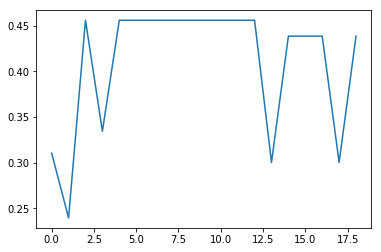

In [79]:
plt.plot(f1scores)

We have k on the x axis and f1 scores on the y axis. According to our grid search, a value of k =11 had the best cross validation score. This graph seems a bit suspicious because of how many spikes and dips we have. Part of the problem may be that so few records actually were denied and it's making our model unstable. It also could be from something with binning the data. Let's see what our recall looks like. 

In [80]:
recallscores = []
for i in range(1,20):
    knn=KNeighborsClassifier(n_neighbors=i, metric = 'euclidean',  weights = 'distance')
    knn.fit(X_train[m2Cols], y_train,)
    predi = knn.predict(X_train[m2Cols])
    recallscores.append(metrics.recall_score(predi, y_train))


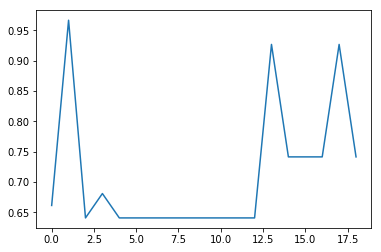

In [81]:
plt.plot(recallscores)

The peak at the start may be to overfitting values close together. It then goes back to around .65. We later have peaks at around 12. It's hard to guess completely why we have those later peaks. Intuitively, I would think increasing k would make our guesses more stable but part of the problem may be our features. The bins might have worked well for the logistic regression where the value is just a weight we multiply if set but it seems not to be working so well here where we are looking for neighbors by distance. In our next model we will use the non binned features. 

Let's use k = 11 as from grid search that had the best results.

In [82]:
knn=KNeighborsClassifier(n_neighbors=11, metric = 'euclidean',  weights = 'distance')
knn.fit(X_train[m2Cols], y_train,)
pred = knn.predict(X_train[m2Cols])

In [83]:
sc = metrics.accuracy_score(y_train,pred)
accuracy_score.append(sc)
sc

0.8997198879551821

Our accuracy score isn't that great as it is under 2 percent higher than a blind guess. 

In [84]:
sc = metrics.precision_score(y_train,pred)
precision_score.append(sc)
sc

0.6410256410256411

Our precision is surprisingly bad. We saw our logistic regression model was around 70 percent. This means we have a lot of false positives, that is rejecting mortgages that we should accept. This should mean our recall is higher though...

In [85]:
sc = metrics.recall_score(y_train,pred)
recall_score.append(sc)
sc

0.35377358490566035

Our recall score is higher than logistic regression but only by around 2 percent which isn't that good considering the drop in precision.

In [86]:

sc = metrics.f1_score(y_train,pred)
f1_score.append(sc)
sc

0.4559270516717325

The f1 score winds up being around the same as we saw in the logistic regression model. This is because we are taking a weighted average.

### KNN model 2

Let's try to create a new knn model without the binned variables. This might help eliminate the oddness we saw in changing k in our first model. 

So which columns? 

Many of our predictors changed the probability of denial when we grouped by the value_counts. They were dmi, pbcr, black, and lvr. dir and hir also were significant but we saw that those are correlated so we should only choose 1 of those features. I will include ccs even though it is related to pbcr since the relationship is not so strong and few rows have a 1 for pbcr. We will include single since that also resulted in around a 5 percent change in our target variable.


In [87]:
m3Cols = ['dmi', 'pbcr', 'ccs', 'black', 'lvr', 'dir', 'single', 'mcs']


In [88]:
gsResults = gs.fit(X_train[m3Cols],y_train)

In [89]:
gsResults.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

Interestingly, here the model does better when we use a distance metric and a k of 3. I think we should plot out the k's like we did in model 1. 

In [90]:
recall = []
for i in range(1,25):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train[m3Cols], y_train)
    predi = knn.predict(X_train[m3Cols])
    recall.append(metrics.recall_score(predi, y_train))
    

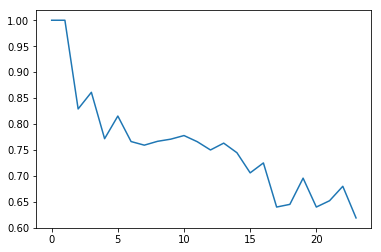

In [91]:
plt.plot(recall)

Our f1 score is very high at k = 1. This is because we have very low bias from using only a single neighbor. When we raise k our bias increases as we see our recall is going down but our variance decreases. This is the behavior I would have expected from model 1 but it may have been impacted by the sparse/binned features. 

Also, when we have large values of k, since there are so few positives, we would tend for the majority class to always vote negative. I think for this model we should guess a low k value would do better. One way to correct for this would be to try different sampling methods. 

In [92]:
f1scores = []
for i in range(1,25):
    knn=KNeighborsClassifier(n_neighbors=i)
    f1scores.append(cross_val_score(knn, X_train[m3Cols], y_train, cv = 5, scoring = 'f1').mean()) #inefficent but small dataset size. 
    

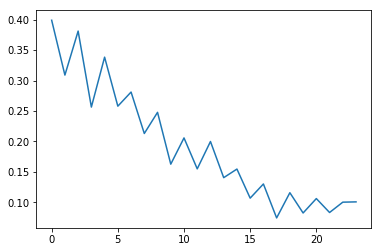

In [93]:
plt.plot(f1scores)

This plot shows how our cross validation scores do at different values of k. We see at very large values of k, our performance rapidly degrades. This is probably because there are so few positive predictions, most of the neighbors will tend to be of the majority class.

I think the value we got at k =3 makes a lot of sense here. We saw from our plot of ks that our recall scores were high and we saw from our grid search that these values did not have much variance.

In [94]:
knn=KNeighborsClassifier(n_neighbors=3, weights='uniform', metric = 'manhattan')

In [95]:
knn.fit(X_train[m3Cols], y_train)
pred = knn.predict(X_train[m3Cols])

In [96]:
sc = metrics.accuracy_score(y_train,pred)
accuracy_score.append(sc)
sc

0.9198879551820728

Our accuracy score is much higher than the logistic regression model and previous knn model. Although 92 percent sounds the same as 90 percent, this is around double the improvement both models did by making a blind guess from 2 percent to 4 percent.

In [97]:
sc = metrics.precision_score(y_train,pred)
precision_score.append(sc)
sc

0.7899159663865546

Our precision score is also much higher at close to 79 percent.

In [98]:
sc = metrics.recall_score(y_train,pred)
recall_score.append(sc)
sc

0.44339622641509435

Our recall is higher than both models at 44 percent.

In [99]:
sc = metrics.f1_score(y_train,pred)
f1_score.append(sc)
sc

0.5679758308157099

And we see from this that our f1 score is also much higher. This is over an 11 percent improvement.

### SVM model 1

SVM is a more complicated model. It involves finding a decision boundary that maximizes the distance between the support vectors. 

SVM has a few hyperparameters. 
1. C - this is the penalty term we use to avoid overfitting. A large c will try to predict the most number of points possible. A low c will allow for more misclassifications (higher bias) but have lower variance.
2. Gamma - This is a parameter for the kernel function. This is how we transform our vector into a higher dimension. The higher the gamma, the more curvature we use. In other words, a low gamma would behave similar to a linear model. 

The kernel function is how we turn into into a higher dimension. Our data is not linear separable, that is we can't completely draw a line to cluster all of our variables into groups - one hint that this is true may be as we saw not every time we have an outlier we have an outlier in all the other features -We should try empirically the rbf and poly kernel.

We could use grid search to find the best values for c and Gamma. We will use the same columns as we did for model 1 and 2. This will allow us to compare the results. I'm also curious how our model will do with binned columns. 

In [100]:
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001] }

In [101]:
from sklearn.svm import SVC  
grid = GridSearchCV(SVC(kernel = 'rbf'),param_grid, cv = 5, scoring = 'f1')
res = grid.fit(X_train[m2Cols],y_train)

In [102]:
res.best_score_

0.41883285816108334

In [103]:
res.best_params_

{'C': 1, 'gamma': 1}

In [104]:
grid = GridSearchCV(SVC(kernel = 'poly'),param_grid, cv = 5, scoring = 'f1')

In [105]:
res = grid.fit(X_train[m2Cols],y_train)

In [106]:
res.best_score_

0.42766653655997916

In [107]:
res.best_params_

{'C': 1, 'gamma': 1}

I used the kernels seperatly just to compare the effects of the different kernels.

We see we do best with a c of 1 and a polynomial kernel. The c of 1 is low - in the middle. - A higher c value would lead to Gamma also is low - in the middle. Let's get more stats from this model.

In [108]:
svc = SVC(C = 1, kernel = 'poly', gamma = 1)
svc.fit(X_train[m2Cols],y_train)

SVC(C=1, gamma=1, kernel='poly')

In [109]:
pred = svc.predict(X_train[m2Cols])

In [110]:
sc = metrics.accuracy_score(y_train,pred)
accuracy_score.append(sc)
sc

0.9053221288515406

This is better than our first k neighbors model.

In [111]:
sc = metrics.precision_score(y_train,pred)
precision_score.append(sc)
sc

0.7362637362637363

Our precision is around where we saw the other models at. 

In [112]:
sc = metrics.recall_score(y_train,pred)
recall_score.append(sc)
sc

0.3160377358490566

but our recall score is very low.

In [113]:
sc = metrics.f1_score(y_train,pred)
f1_score.append(sc)
sc

0.44224422442244227

The low recall score results in a low f1 score. We may do better with the non binned columns.

### SVM Model 2

We will use the columns we tried with the second knn since that model did really well compared to the logistic regression.

In [114]:
param_grid = {'C': [0.1,1, 10],
              'gamma': [1,0.1,0.01],
              'kernel': ['poly']} # we have a lot more features than the previous model and I ran it once and it showed poly was better than rbf. It will be too long to execute this each time.

In [115]:
#grid = GridSearchCV(SVC(),param_grid, cv = 5, scoring = 'f1', verbose = 2, n_jobs = -1)
#res = grid.fit(X_train[m3Cols],y_train)

In [116]:
res.best_params_

{'C': 1, 'gamma': 1}

Let's use these parameters

In [117]:
svc = SVC(C = 1, kernel = 'poly', gamma = .1)
svc.fit(X_train[m3Cols],y_train)

SVC(C=1, gamma=0.1, kernel='poly')

In [118]:
pred = svc.predict(X_train[m3Cols])

In [119]:
sc = metrics.accuracy_score(y_train,pred)
accuracy_score.append(sc)
sc

0.9019607843137255

In [120]:
sc = metrics.precision_score(y_train,pred)
precision_score.append(sc)
sc

0.7283950617283951

In [121]:
sc = metrics.recall_score(y_train,pred)
recall_score.append(sc)
sc

0.2783018867924528

In [122]:
sc = metrics.f1_score(y_train,pred)
f1_score.append(sc)
sc

0.40273037542662116

With this model, we see that our precision score is in the middle but our recall score is very low, even lower than what we saw when using binned columns. This is very poor considering the added complexity of the model.

#### Model Comparison. 

In [123]:
scores = pd.DataFrame([accuracy_score, precision_score, recall_score, f1_score])
#scores.columns = ['model1','model2','model3','model4']
scores.index = ['accuracy_score', 'precision_score', 'recall_score', 'f1_score']
scores

,0,1,2,3,4
accuracy_score,0.904762,0.899720,0.919888,0.905322,0.901961
precision_score,0.714286,0.641026,0.789916,0.736264,0.728395
recall_score,0.330189,0.353774,0.443396,0.316038,0.278302
f1_score,0.451613,0.455927,0.567976,0.442244,0.402730


It is pretty clear from these stats that the 3rd model (the second knn model) is the best. The f1_score is significantly higher that the other scores showing it has better recall and precision. 

Compared to our logistic regression model, this model does not perform badly because we aren't using so many features and we don't have so many rows. It is a fairly fast and quick model to use. 

Our svm models (models 4 and 5) though seem to be worse than both our logistic regression model and our knn models. It makes little sense to use this model because it is more complex and it's f1 score is much lower. 

In [140]:
knn=KNeighborsClassifier(n_neighbors=3, weights='uniform', metric = 'manhattan')
cross_val_score(knn, X_train[m3Cols], y_train, cv = 5, scoring = 'f1')

array([0.38596491, 0.41269841, 0.43076923, 0.4137931 , 0.29411765])

Our cross val scores also seem to be around .4 except for the last one which is around .3. It is slightly concerning for us since we saw above tht model 2 actually had a recall score of .567. This makes it seem like we are overfitting. Let's see what happens if we increase k.

In [139]:
knn=KNeighborsClassifier(n_neighbors=5, weights='uniform', metric = 'manhattan')
cross_val_score(knn, X_train[m3Cols], y_train, cv = 5, scoring = 'f1')

array([0.37037037, 0.28571429, 0.42622951, 0.36666667, 0.17241379])

All of our f1 scores went down and it doesn't really seem like there is less variance between the scores. Let's try with 1 more k

In [142]:
knn=KNeighborsClassifier(n_neighbors=9, weights='uniform', metric = 'manhattan')
cross_val_score(knn, X_train[m3Cols], y_train, cv = 5, scoring = 'f1')

array([0.26415094, 0.29090909, 0.32142857, 0.15686275, 0.2       ])

We see that increasing our k doesn't really seem to be helping our scores anymore. We also saw this above with our grid search. Because of this, I think we should use k =3. If we had more positive cases this model would be able to do significantly better. 

Test Data

In [157]:
knn=KNeighborsClassifier(n_neighbors=3, weights='uniform', metric = 'manhattan')
knn.fit(X_train[m3Cols],y_train)
pred = knn.predict(X_test[m3Cols])


In [161]:
metrics.precision_score(y_test,pred)

0.5

In [159]:
metrics.f1_score(y_test,pred)

0.3865546218487395

Our f1 score on our test data is around the .4 we saw when we did our cross validation. This is a bit lower than what we got from the logistic regression actually.

Let's plot an auc curve.

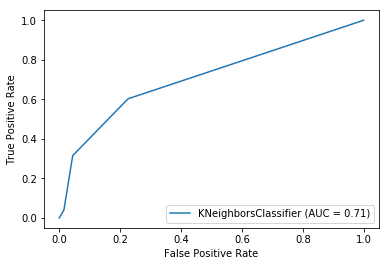

In [164]:
metrics.plot_roc_curve(knn, X_test[m3Cols], y_test) 

Our auc curve is .71 which is decent. Auc is on a scale of 0 to 1 where 1 be be a perfect model. 

I specified drop_intermidiate = False to tell scikit learn to evaluate all the points. This didn't really change our curve though.

In [165]:
metrics.precision_score(y_test, pred)

0.5

Our precision score is very low compared to the other models.

In [166]:
metrics.recall_score(y_test, pred)

0.3150684931506849

Our recall score also is a bit lower. 

Overall this model seems to be overfitting the data a bit. I think the problem with the knn here might be the nature of the data where 88 percent of the values have values of 0. It is a no win situation because if k is too low then we will overfit but if k is too high then the majority will always vote the loan was not denied. Increasing k beyond 3 significantly detriments our model. I think though this model still is better than the svc which had very bad numbers. I would rethink using a distance based model for this problem. 

Conclusions.

1. We saw that there does seem to be some discrimination based on being black in the housing market as we saw that being black results in an increase probability of denial, although we also saw that black people have lower credit scores and we can't identify whether the low credit score is because they are black or other reasons.
2. We saw that the knn model does significantly better than SVM and logistic regression model for this dataset